# Aygaz Veri Analizi Bootcamp Bitirme Projesi

#### Merhaba! Ben Kaan Kılıç. Lisans eğitimimi Orta Doğu Teknik Üniversitesi İnşaat Mühendisliği bölümünde tamamladıktan sonra, İnşaat Proje Yönetimi alanında yüksek lisans eğitimine Boğaziçi Üniversitesi'nde başladım. Veri bilimiyle tanıştıktan sonra, bu alanda kendimi geliştirip ileride bir veri bilimci olarak çalışmayı hedefliyorum.

#### Bu veri bilimi projesinde New York AirBNB veri setini inceledim.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import re
from PIL import Image

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#### Veri setinde 'name' ve 'host_name' sütunlarındaki NaN verileri 'Unknown' olarak, 'last_review' ve 'reviews_per_month' verileri içerisinde NaN olan satırları da '0' olarak doldurdum. Ayrıca fiyatı 0 olarak girilen ilanları da verinin sağlıklı bir şekilde incelenebilmesi için veri setinden kaldırdım.

In [7]:
data[['name','host_name']] = data[['name','host_name']].fillna('Unknown')
data = data[data['price'] != 0]
data[['last_review','reviews_per_month']] = data[['last_review','reviews_per_month']].fillna('0')

In [8]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

#### Verimizdeki numeric değişkenler arasındaki korelasyonu incelediğimizde ise (pozitif veya negatif) 0.23'ten daha büyük bir korelasyon göremiyoruz.

/var/folders/7w/xnh8ywsd5ddgllwhmjygxqgr0000gn/T/ipykernel_1069/4025453871.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = numerical_columns.corr()


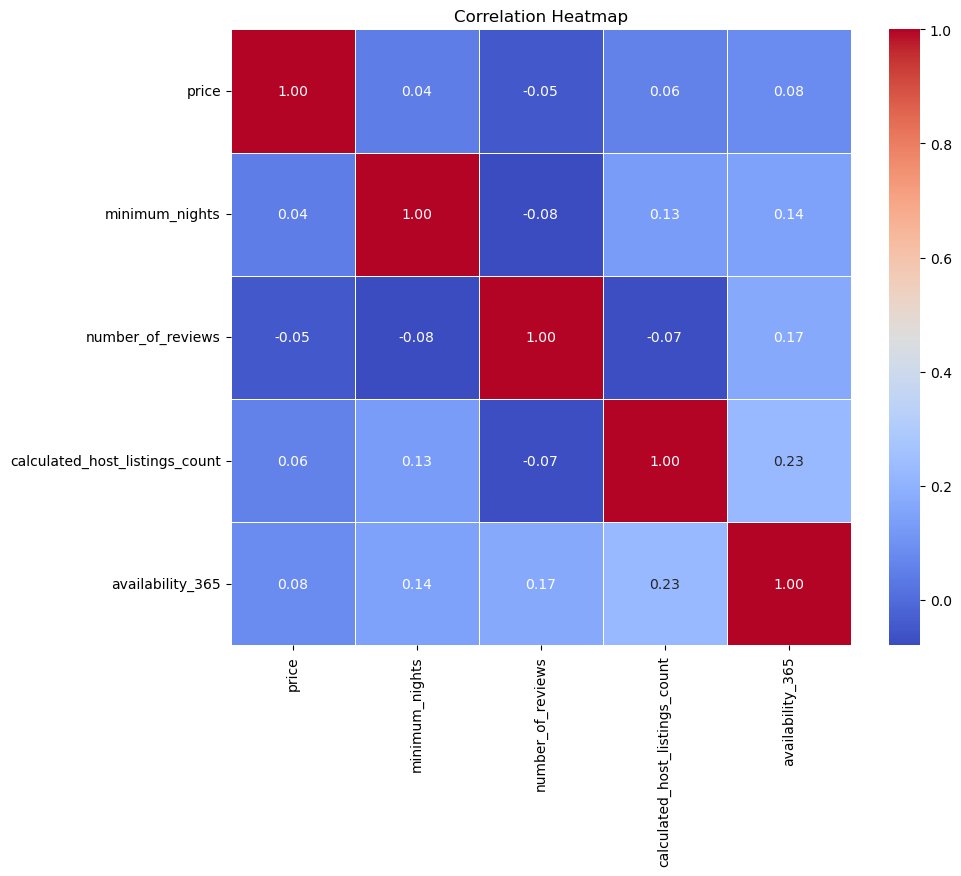

In [9]:
numerical_columns = data[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]


correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### İlan başlıklarını incelediğimizde en sık karşılaştığımız kelimelerin "Room", "Bedroom", "Private" olduğunu görüyoruz.

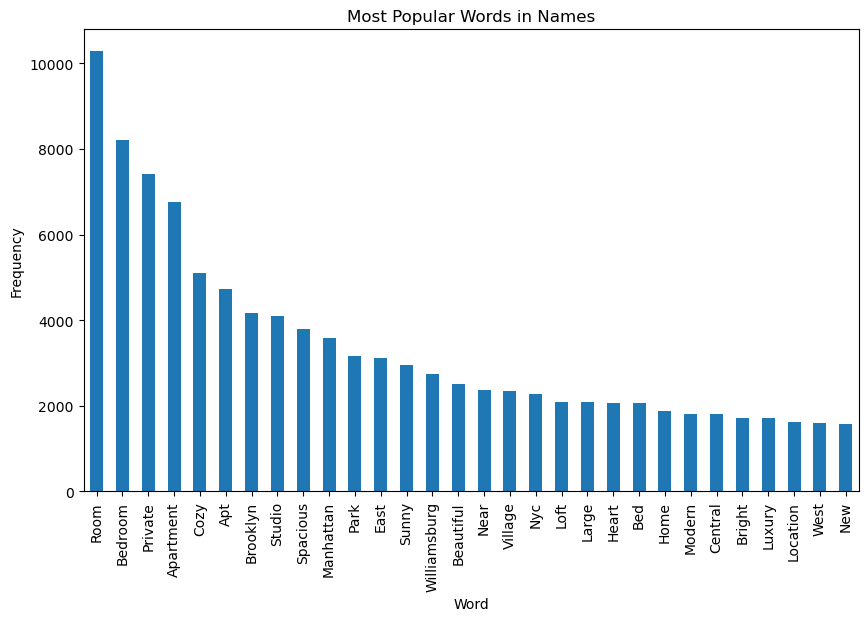

In [49]:
name_list = data['name']
names_used = []
pattern = r'\W+'
excluded_words = set(['on', 'in', 'at', 'and', 'the', 'to', 'w', 'of', 'a', 'an', 'for', 'with','from']) 

for i in name_list:
    x = re.split(pattern, i)
    for adj in x:
        if len(adj) > 0 and not adj.isnumeric() and adj.lower() not in excluded_words:
            names_used.append(adj.lower())

word_counts_30 = pd.Series(names_used).str.capitalize().value_counts().nlargest(30)

plt.figure(figsize=(10, 6))
word_counts_30.plot(kind='bar')
plt.title('Most Popular Words in Names')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

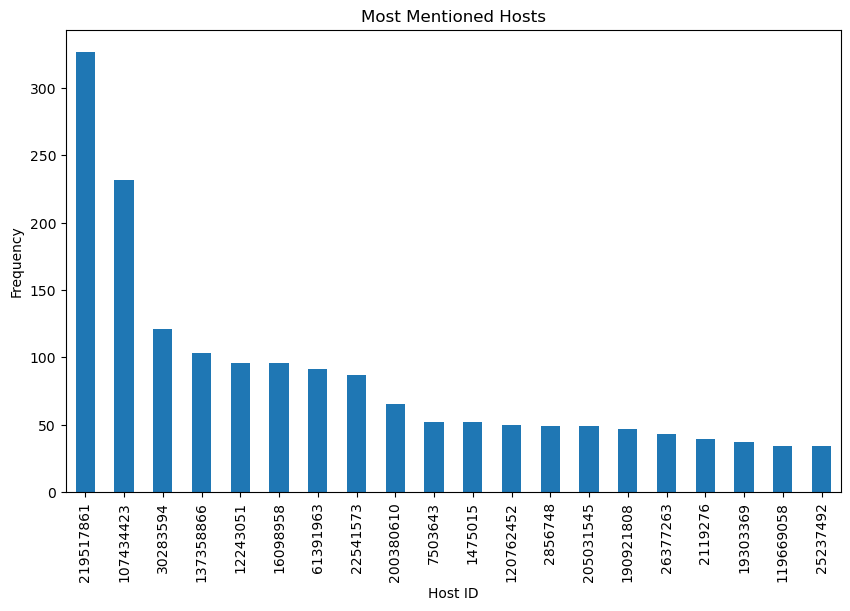

In [11]:
top_hosts = data['host_id'].value_counts(ascending=False).head(20)
plt.figure(figsize=(10, 6))
top_hosts.plot(kind='bar')
plt.title('Most Mentioned Hosts')
plt.xlabel('Host ID')
plt.ylabel('Frequency')
plt.show()

#### Veri setimizdeki ilanların en çok Manhattan, sonra da Brooklyn bölgelerinden verildiğini görebiliriz.

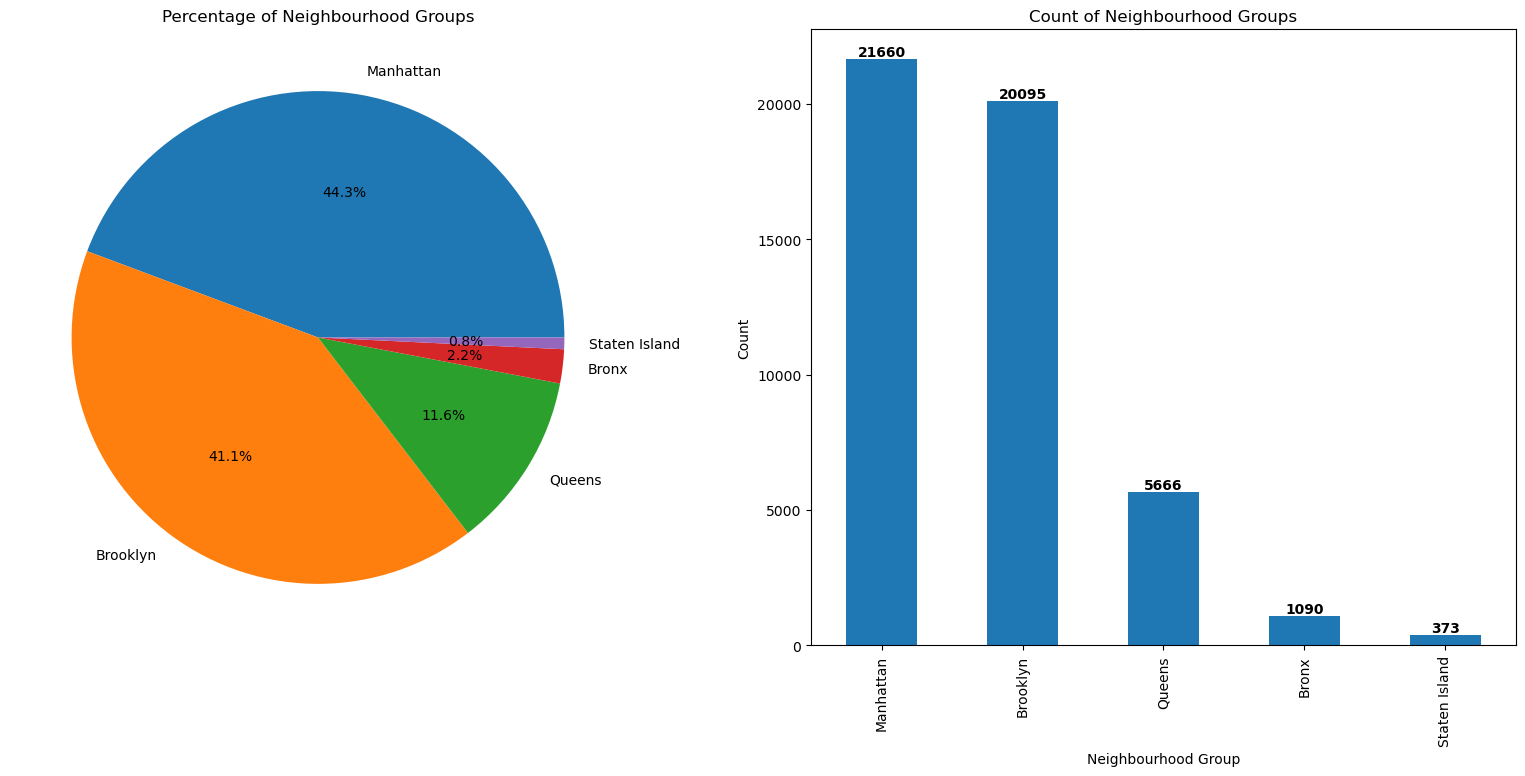

In [12]:
neighbour_counts = data['neighbourhood_group'].value_counts()
total_count = neighbour_counts.sum()

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pie chart on the left side
axes[0].pie(neighbour_counts, labels=neighbour_counts.index, autopct='%1.1f%%')
axes[0].set_title('Percentage of Neighbourhood Groups')

 # Bar chart on the right side
neighbour_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Count of Neighbourhood Groups')
axes[1].set_xlabel('Neighbourhood Group')
axes[1].set_ylabel('Count')

for i, count in enumerate(neighbour_counts):
        axes[1].text(
            x=i,
            y=count,
            s=str(count),
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
plt.show()

#### Her bir mahallenin kendi bölgesine göre gruplandırmış halini de görebiliriz.

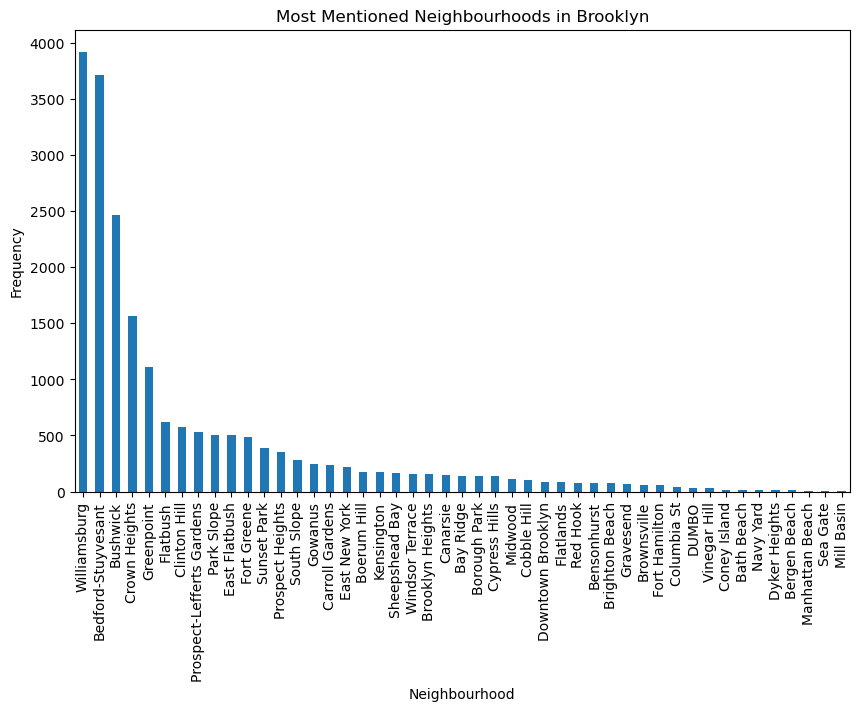

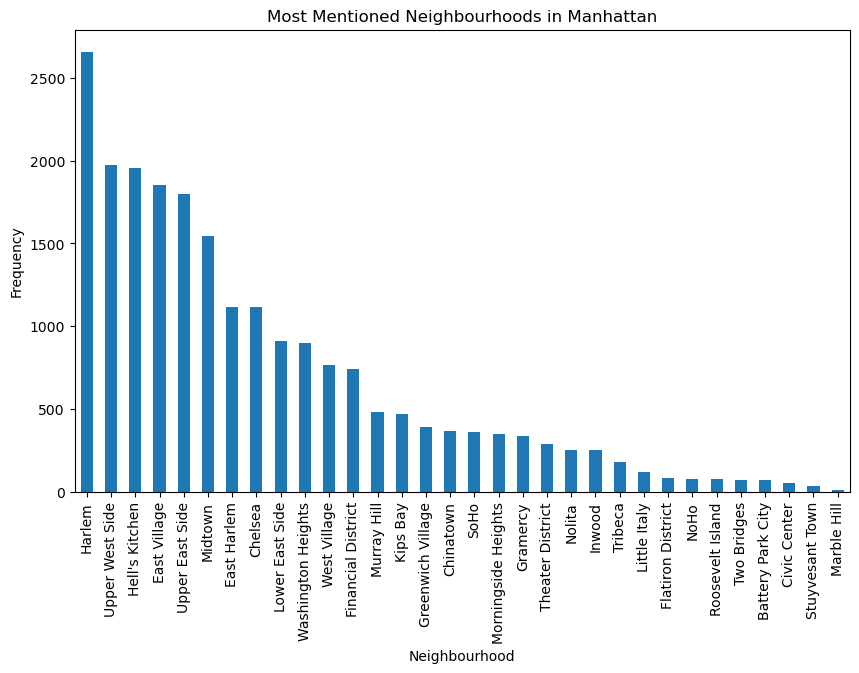

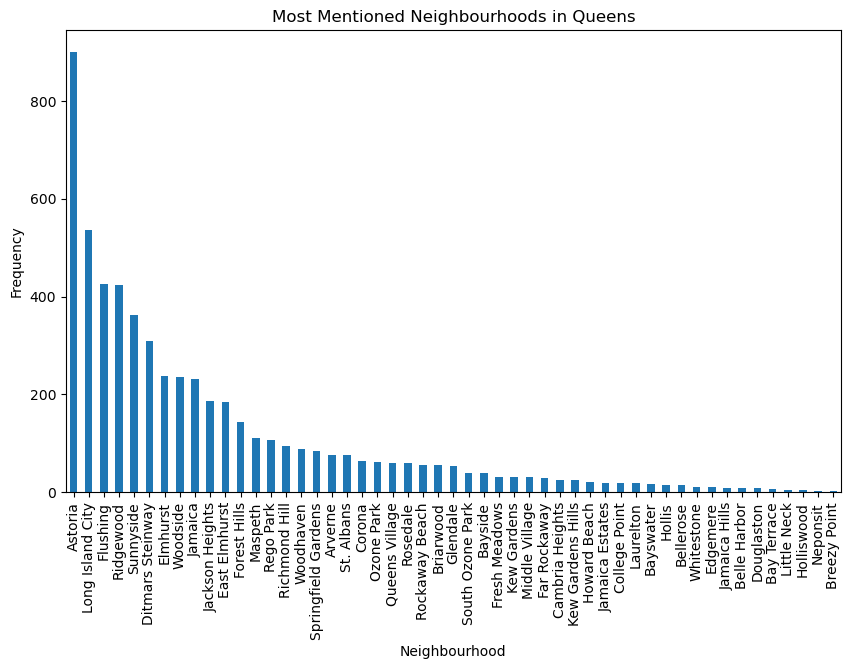

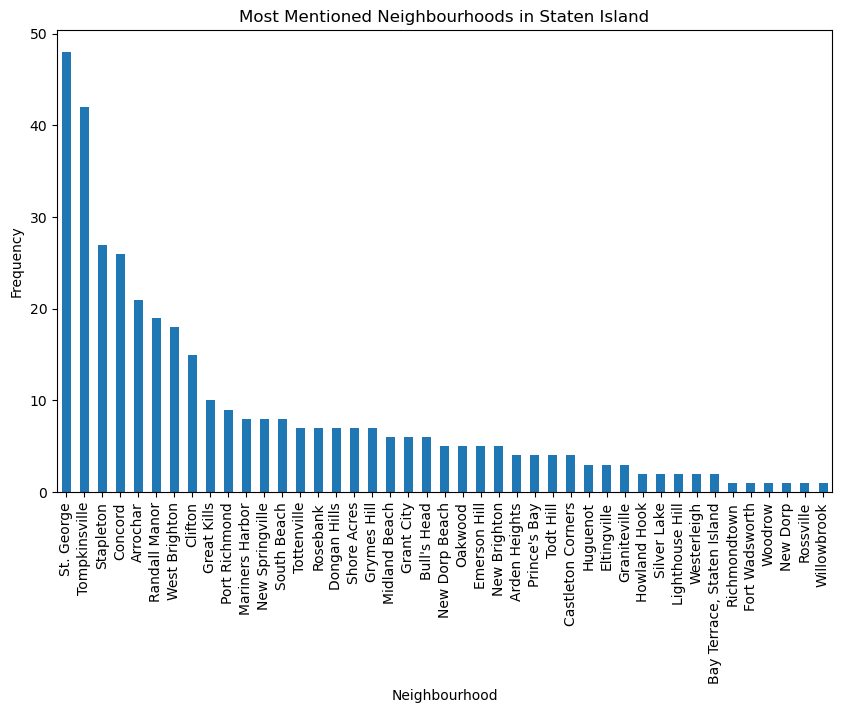

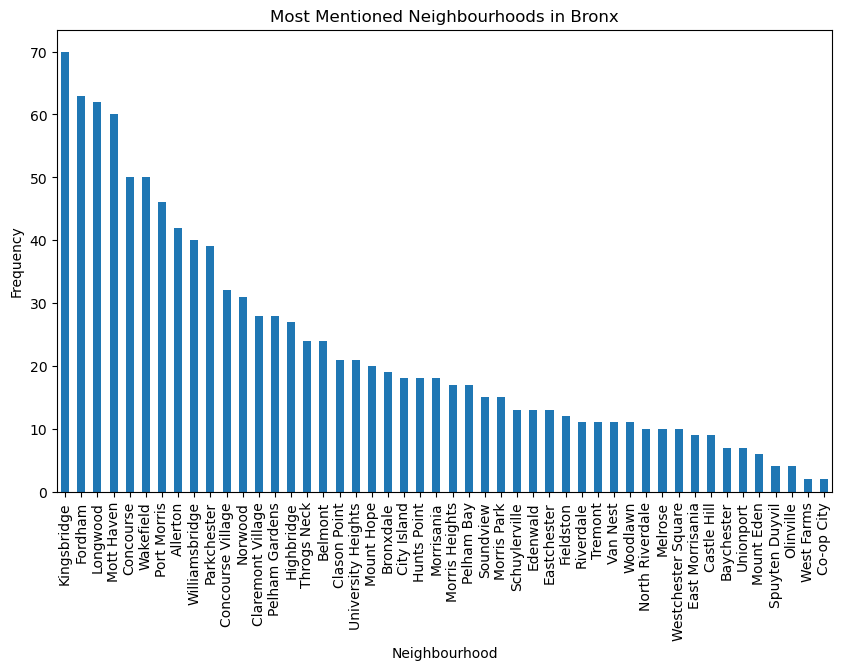

In [13]:
unique_groups = data['neighbourhood_group'].unique()

for group in unique_groups:
    group_data = data[data['neighbourhood_group'] == group]
    group_neighbourhood_counts = group_data['neighbourhood'].value_counts()

    plt.figure(figsize=(10, 6))
    group_neighbourhood_counts.plot(kind='bar')
    plt.title(f'Most Mentioned Neighbourhoods in {group}')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Frequency')
    plt.show()

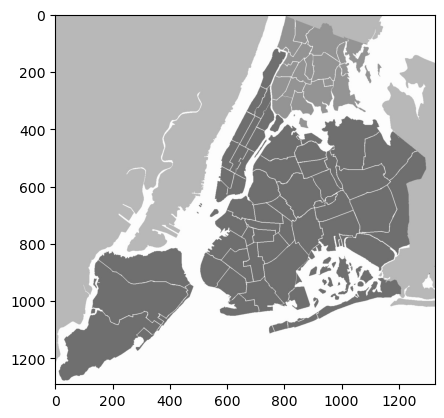

In [14]:
with Image.open("NYC_image.png") as bg:
    plt.imshow(bg)

#### Enlem ve boylama göre verilerin dağılım grafiğinde işlenmiş halini görebiliriz.

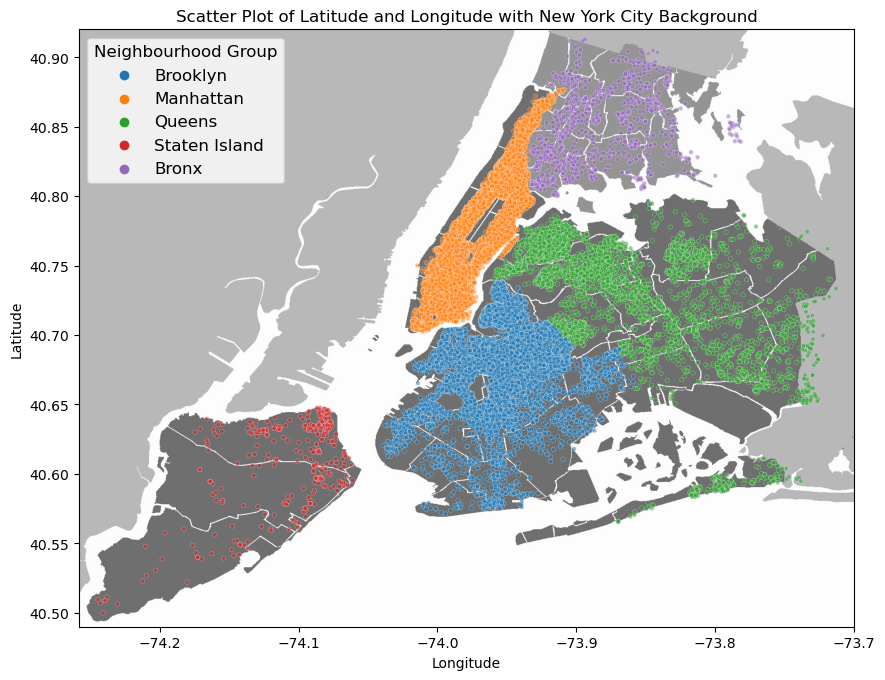

In [25]:

plt.figure(figsize=(10, 8))

plt.imshow(bg,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])

sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', data=data, s=10, alpha=0.5)

plt.title('Scatter Plot of Latitude and Longitude with New York City Background')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Neighbourhood Group', title_fontsize='large', fontsize='large')
plt.show()

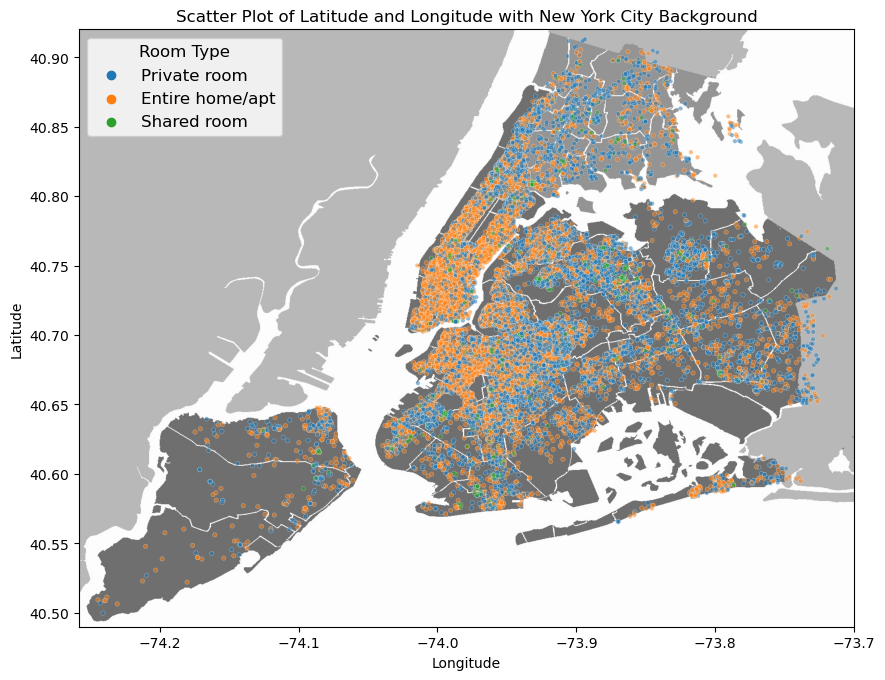

In [24]:

plt.figure(figsize=(10, 8))

plt.imshow(bg,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])

sns.scatterplot(x='longitude', y='latitude', hue='room_type', data=data, s=10, alpha=0.5)

plt.title('Scatter Plot of Latitude and Longitude with New York City Background')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Room Type', title_fontsize='large', fontsize='large')
plt.show()


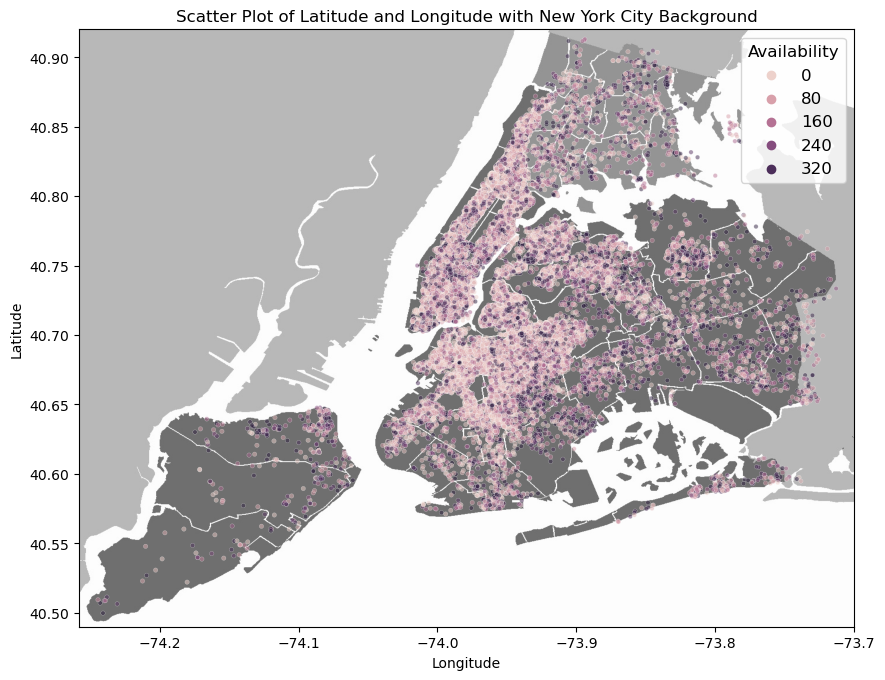

In [23]:

plt.figure(figsize=(10, 8))

plt.imshow(bg,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])

sns.scatterplot(x='longitude', y='latitude', hue='availability_365', data=data, s=10, alpha=0.5)

plt.title('Scatter Plot of Latitude and Longitude with New York City Background')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Availability', title_fontsize='large', fontsize='large')
plt.show()


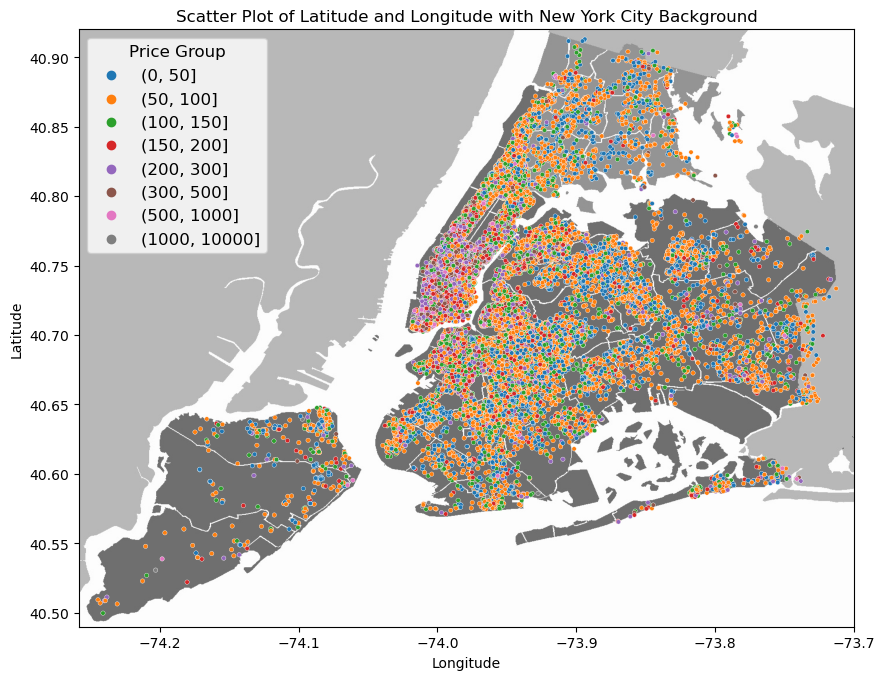

In [22]:
plt.figure(figsize=(10, 8))
plt.imshow(bg,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
price_bins = [0, 50, 100, 150, 200, 300, 500, 1000, data['price'].max()]
data['price_group'] = pd.cut(data['price'], bins=price_bins)
sns.scatterplot(x='longitude', y='latitude', hue='price_group', data=data, s=10)
plt.title('Scatter Plot of Latitude and Longitude with New York City Background')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price Group', title_fontsize='large', fontsize='large')
plt.show()


#### İlanların büyük bir kısmının 50 - 100 dolar aralığında olduğunu görebiliriz.

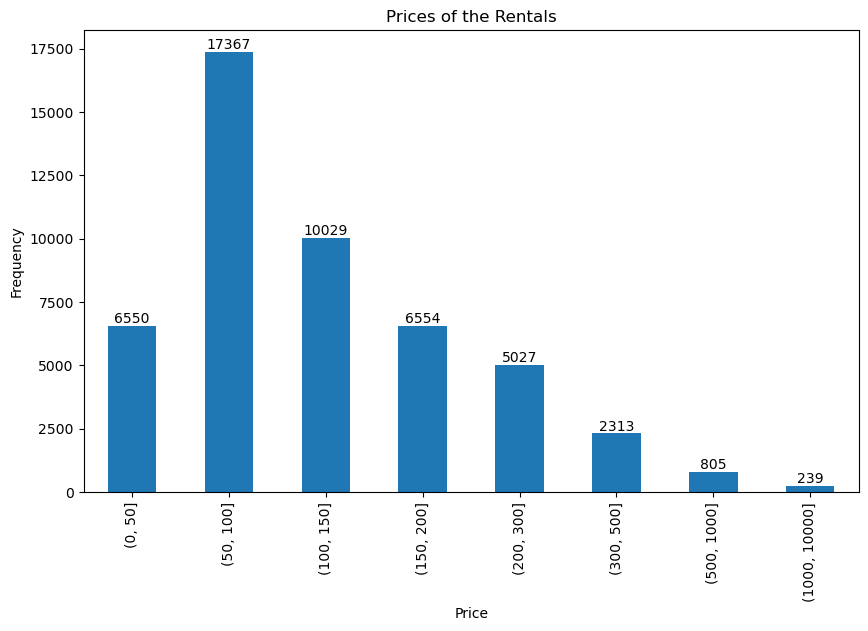

In [31]:
prices= data['price_group'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
prices.plot(kind='bar')
plt.title('Prices of the Rentals')
plt.xlabel('Price')
plt.ylabel('Frequency')
for index, value in enumerate(prices):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

#### Fiyatların mahalle gruplarına göre dağılımını incelediğimizde düşük fiyatlı ilanların çoğunlukla Brooklyn, Queens gibi 'suburb' bölgelerden verildiği, fiyat arttıkça ilanların Manhattan bölgesinde yoğunlaştığını görebiliriz.

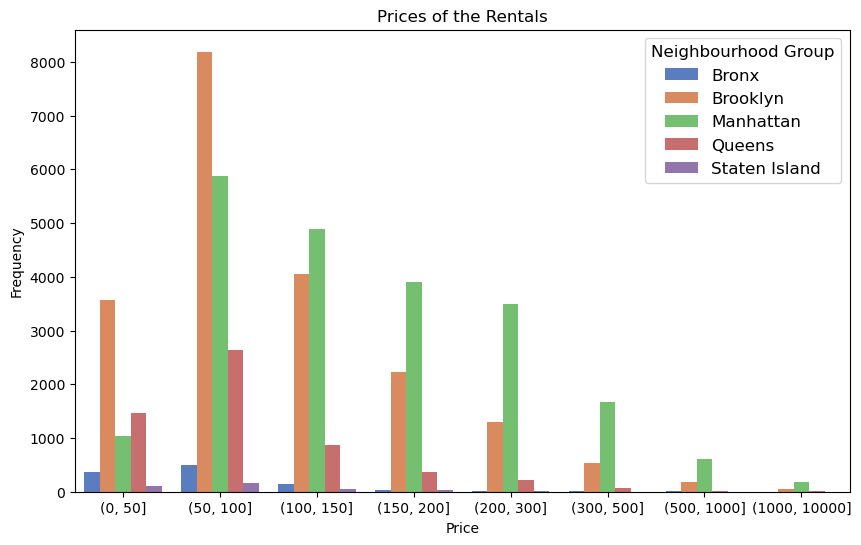

In [50]:
df_grouped = data.groupby(['price_group', 'neighbourhood_group']).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
sns.barplot(x='price_group', y='counts', hue='neighbourhood_group', data=df_grouped, palette='muted')
plt.title('Prices of the Rentals')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.legend(title='Neighbourhood Group', title_fontsize='large', fontsize='large')
plt.show()

#### Fiyatların oda tiplerine göre dağılımını incelediğimizde düşük fiyatlı ilanların çoğunlukla paylaşımlı ya da tek kişilik odalardan oluştuğu, fiyat arttıkça ilanların tüm evi kapsadığını görebiliriz.

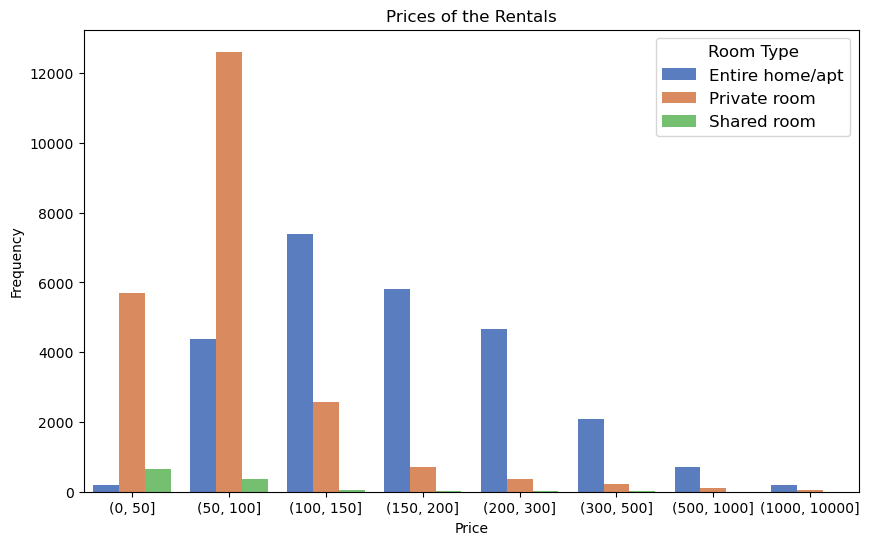

In [51]:
df_grouped = data.groupby(['price_group', 'room_type']).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.barplot(x='price_group', y='counts', hue='room_type', data=df_grouped, palette='muted')
plt.title('Prices of the Rentals')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.legend(title='Room Type', title_fontsize='large', fontsize='large')
plt.show()

### Outlier verileri eledikten sonra oda tipine göre ilanların fiyat analizlerini bu şekilde inceleyebiliriz.

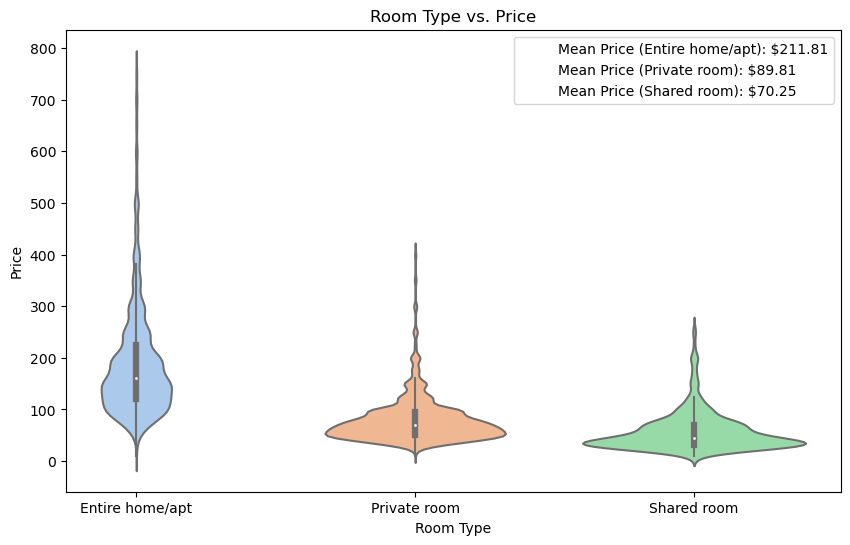

In [52]:
mean_prices = data.groupby('room_type')['price'].mean()

std_prices = data.groupby('room_type')['price'].std()

data_filtered = data.groupby('room_type').apply(lambda x: x[(x['price'] >= mean_prices[x['room_type'].iloc[0]] - 2 * std_prices[x['room_type'].iloc[0]]) & 
                                                            (x['price'] <= mean_prices[x['room_type'].iloc[0]] + 2 * std_prices[x['room_type'].iloc[0]])])

plt.figure(figsize=(10, 6))
sns.violinplot(x='room_type', y='price', data=data_filtered, palette='pastel')
plt.title('Room Type vs. Price')
plt.xlabel('Room Type')
plt.ylabel('Price')
for room_type, mean_price in mean_prices.items():
    plt.plot([], [], label=f'Mean Price ({room_type}): ${mean_price:.2f}', marker='', linestyle='')
plt.legend()
plt.show()

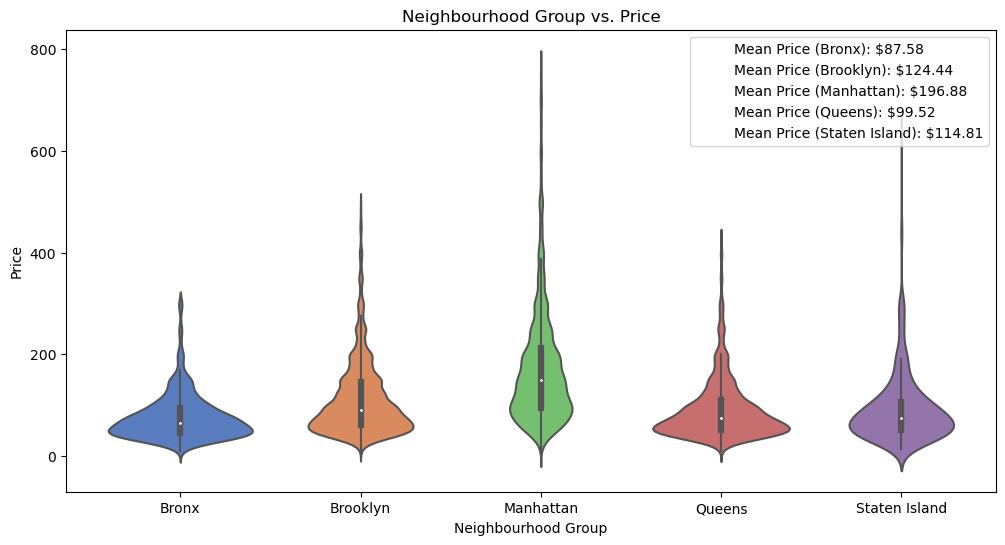

In [35]:
mean_prices = data.groupby('neighbourhood_group')['price'].mean()
std_prices = data.groupby('neighbourhood_group')['price'].std()

data_filtered = data.groupby('neighbourhood_group').apply(lambda x: x[(x['price'] >= mean_prices[x['neighbourhood_group'].iloc[0]] - 2 * std_prices[x['neighbourhood_group'].iloc[0]]) & 
                                                                      (x['price'] <= mean_prices[x['neighbourhood_group'].iloc[0]] + 2 * std_prices[x['neighbourhood_group'].iloc[0]])])
plt.figure(figsize=(12, 6))
sns.violinplot(x='neighbourhood_group', y='price', data=data_filtered, palette='muted')
plt.title('Neighbourhood Group vs. Price')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')

for neighbourhood_group, mean_price in mean_prices.items():
    plt.plot([], [], label=f'Mean Price ({neighbourhood_group}): ${mean_price:.2f}', marker='', linestyle='')

plt.legend()
plt.show()

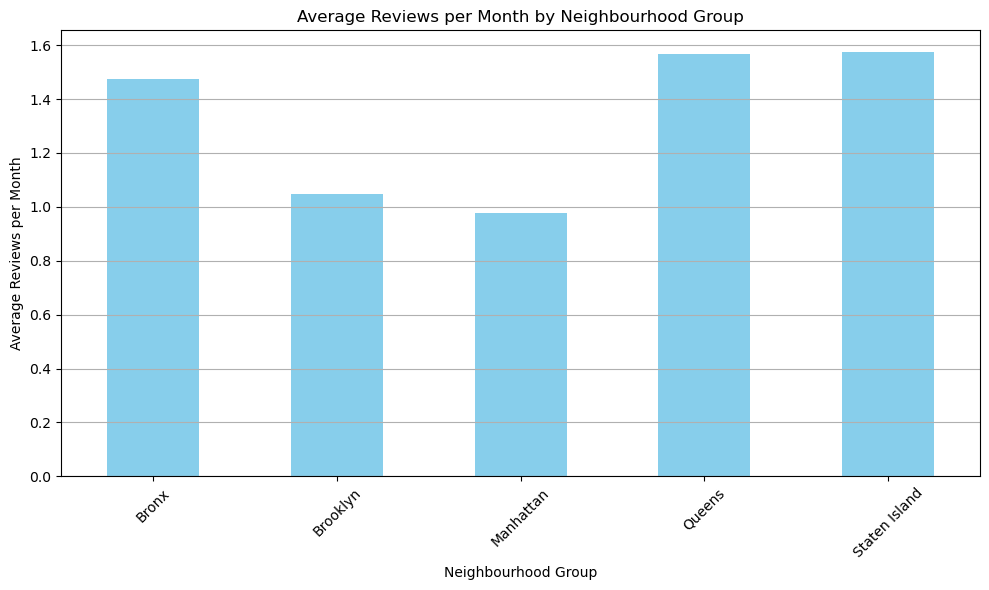

In [36]:
data['reviews_per_month'] = pd.to_numeric(data['reviews_per_month'], errors='coerce').dropna()
mean_reviews_per_month = data.groupby('neighbourhood_group')['reviews_per_month'].mean()
plt.figure(figsize=(10, 6))
mean_reviews_per_month.plot(kind='bar', color='skyblue')
plt.title('Average Reviews per Month by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Reviews per Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### İlanların aylık ortalama yorum sayılarıyla fiyatlarını karşılaştırdığımızda fiyat arttıkça yorum sayısının azaldığını söyleyebiliriz.

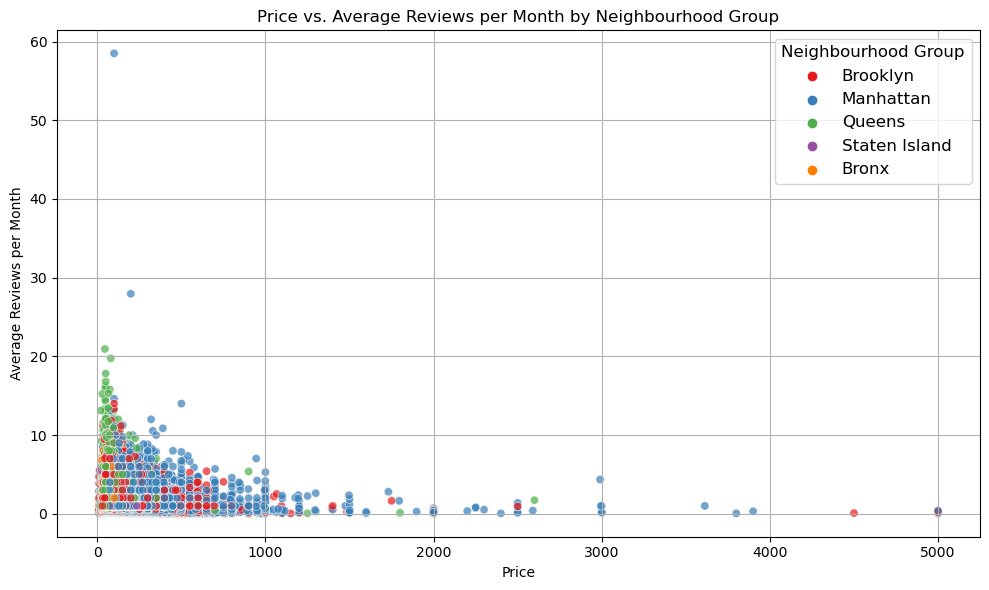

In [54]:
filtered_data = data[(data['price'] <= 5000) & (data['reviews_per_month'] > 0)]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='reviews_per_month', hue='neighbourhood_group', data=filtered_data, palette='Set1', alpha=0.7)
plt.title('Price vs. Average Reviews per Month by Neighbourhood Group')
plt.xlabel('Price')
plt.ylabel('Average Reviews per Month')
plt.legend(title='Neighbourhood Group', title_fontsize='large', fontsize='large')
plt.grid(True)
plt.tight_layout()
plt.show()

#### İlan sahiplerinin ilan sayısı ve o ilanların ortalama fiyatlarını incelediğimizde, yoğunlukla ilan sayısı arttıkça fiyatın düştüğünü görebiliriz. 

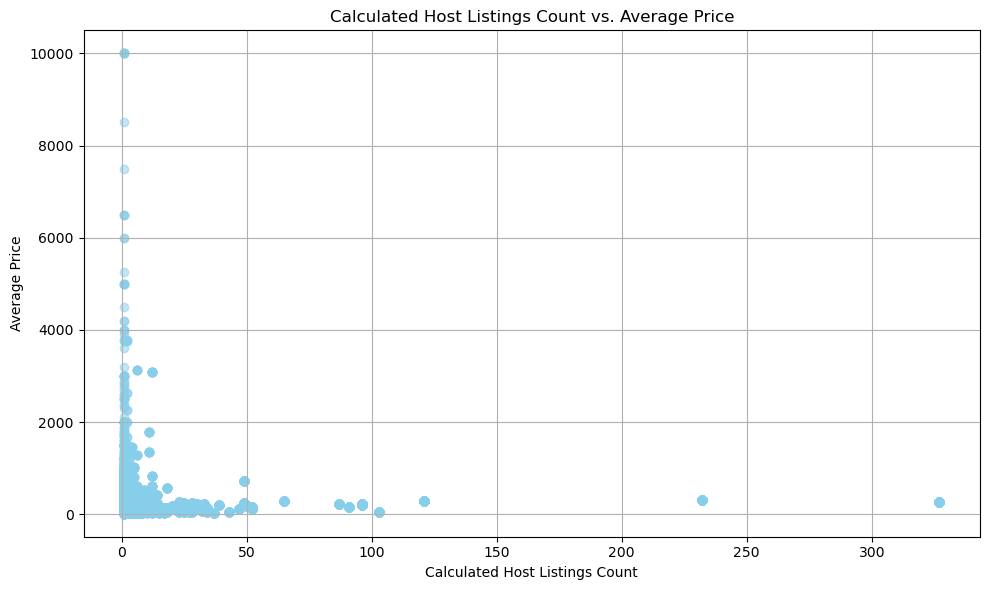

In [58]:
average_price_per_host = data.groupby('host_id')['price'].mean().reset_index()
average_price_per_host.rename(columns={'price': 'average_price'}, inplace=True)

merged_data = data.merge(average_price_per_host, on='host_id')

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['calculated_host_listings_count'], merged_data['average_price'], alpha=0.5, color='skyblue')
plt.title('Calculated Host Listings Count vs. Average Price')
plt.xlabel('Calculated Host Listings Count')
plt.ylabel('Average Price')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Minimum gece sayılarını bölgelere göre incelediğimizde Manhattan bölgesindeki ilanların minimum gece sayısının diğer bölgelerden daha fazla olduğunu görmekteyiz.

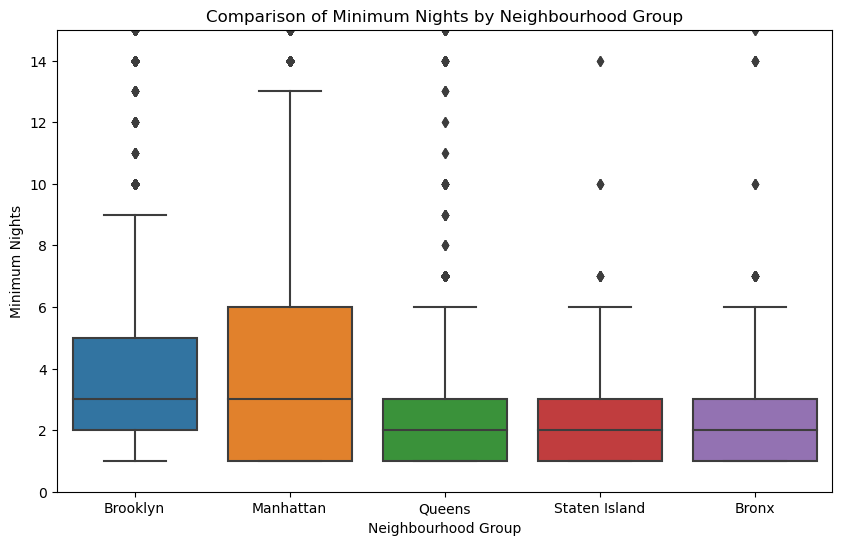

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_group', y='minimum_nights', data=data)
plt.ylim(0, 15)
plt.title('Comparison of Minimum Nights by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Minimum Nights')
plt.show()

#### Minimum gece sayılarını oda tiplerine göre incelediğimizde ise tüm evi kiralayan kullanıcıların daha fazla gece konakladığını söyleyebiliriz.

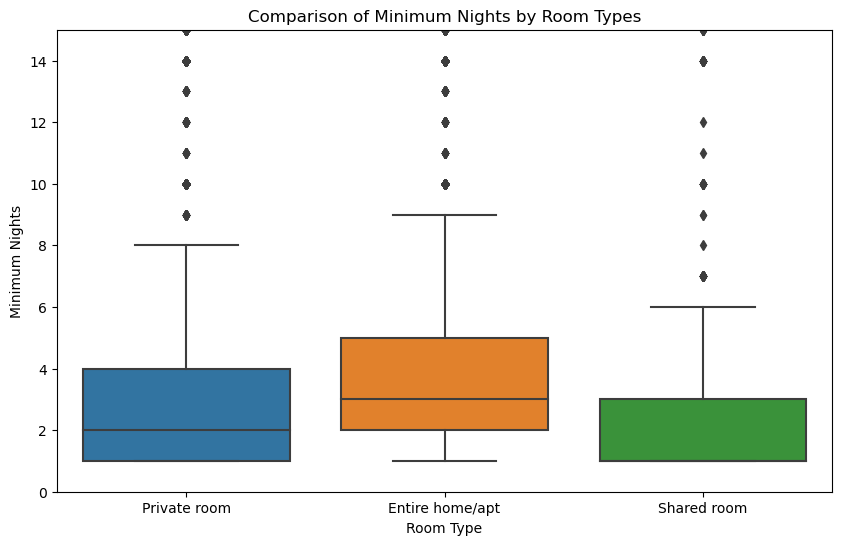

In [40]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='room_type', y='minimum_nights', data=data)
plt.ylim(0, 15)
plt.title('Comparison of Minimum Nights by Room Types')
plt.xlabel('Room Type')
plt.ylabel('Minimum Nights')
plt.show()

#### Fiyatları oda tiplerine göre incelediğimizde yine ev kiralayan kullanıcıların daha fazla para ödediğini görmekteyiz. 

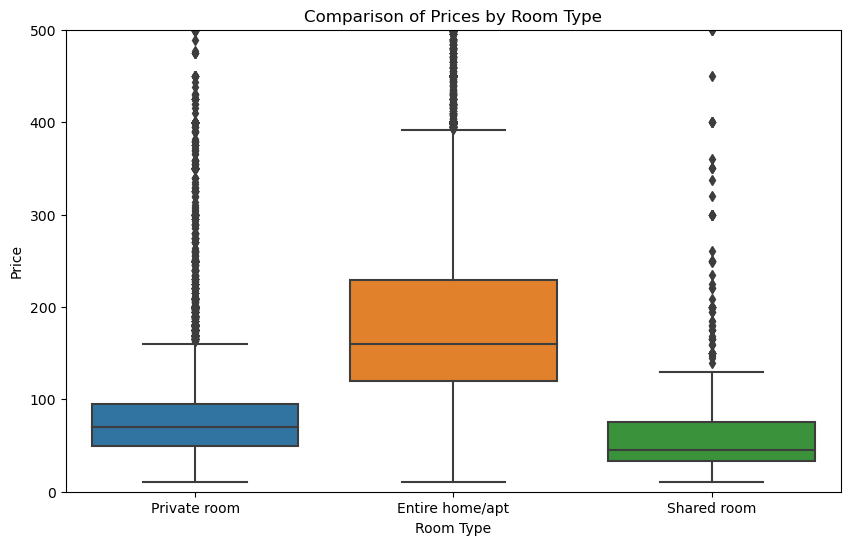

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=data)
plt.title('Comparison of Prices by Room Type')
plt.ylim(0,500)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

#### Manhattan bölgesinin 'boxplot' grafiği üzerinden incelediğimizde de fiyatların daha yüksek olduğunu görmekteyiz.  

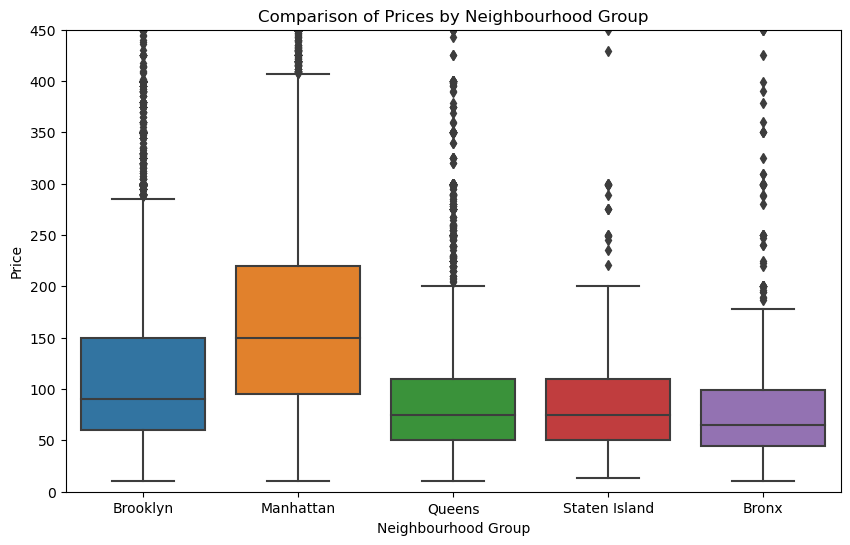

In [44]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='neighbourhood_group', y='price', data=data)
plt.title('Comparison of Prices by Neighbourhood Group')
plt.ylim(0,450)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')
plt.show()